In [1]:
!pip install -r requirements.txt

Data loaded and split into training and testing sets.

--- Finding optimal parameters using auto_arima ---
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=757.714, Time=2.27 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=757.826, Time=0.18 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=755.750, Time=0.25 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=756.380, Time=0.16 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=755.499, Time=0.06 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=755.982, Time=0.17 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=757.649, Time=0.30 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=756.771, Time=0.08 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=756.022, Time=0.10 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=756.011, Time=0.06 sec
 ARIMA(2,1,1)(0,1,0)[12]             : AIC=757.976, Time=0.12 sec
 ARIMA(1,1,0)(0,1,0)[12] intercept   : AIC=757.438, Time=0.12 sec

Best model:  ARIMA(1,1,0)(0,1,0)[12]          
Total fit 

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


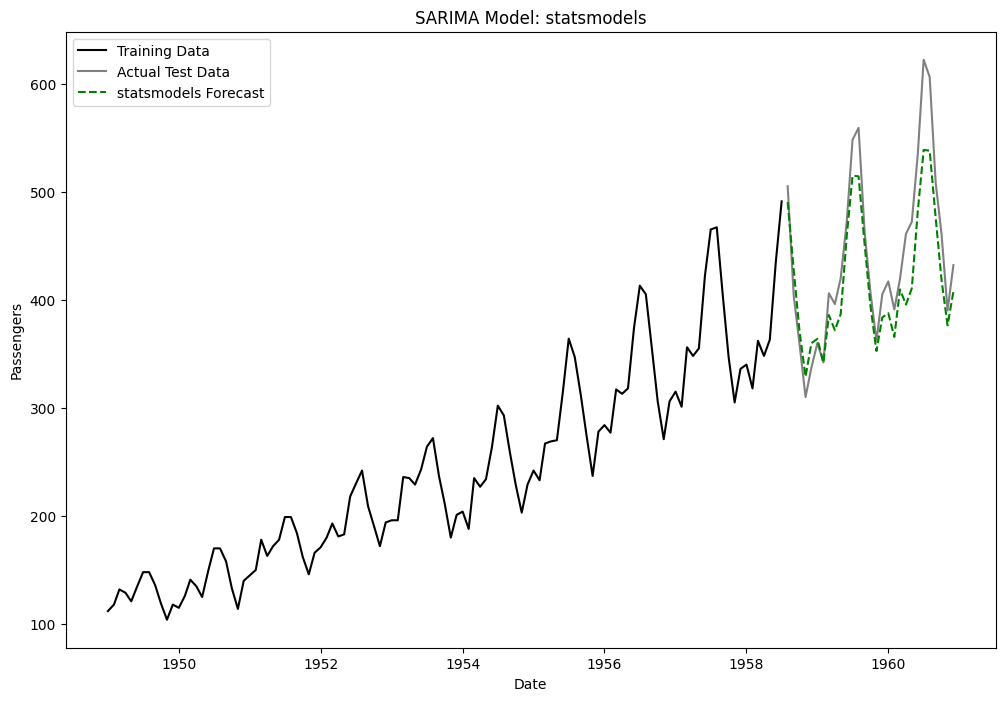

In [4]:
# Installing the necessary libraries
# Note: You need to install these libraries in your environment if you haven't already.
# pip install statsmodels numpy pandas matplotlib scikit-learn pmdarima

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima

# Alternative method to load the AirPassengers dataset using pandas
# URL for the AirPassengers dataset (CSV format)
data_url = 'https://raw.githubusercontent.com/AileenNielsen/TimeSeriesAnalysisWithPython/master/data/AirPassengers.csv'

# Load the dataset into a pandas DataFrame
data = pd.read_csv(data_url)

# Convert the 'Month' column to datetime objects and set it as the index
data['Month'] = pd.to_datetime(data['Month'], format='%Y-%m')
data = data.set_index('Month')['#Passengers']

# Display the first few rows of the loaded data
# print(data.head()) # Uncomment to see the head of the data

# Split the data into training and testing sets manually using pandas slicing
# 80% of the data will be used for training and 20% for testing.
split_index = int(len(data) * 0.8)
train = data[:split_index]
test = data[split_index:]

print("Data loaded and split into training and testing sets.")

# --- 2. Model Fitting and Forecasting ---

# Automatically find optimal SARIMA parameters using pmdarima's auto_arima
# The seasonal=True argument is crucial for seasonal data. m=12 for monthly data.
# The trace=True argument will print the different models being tested.
print("\n--- Finding optimal parameters using auto_arima ---")
optimal_model = auto_arima(train, seasonal=True, m=12, trace=True,
                           error_action='ignore', suppress_warnings=True)

# Extract the optimal order and seasonal order
optimal_order = optimal_model.order
optimal_seasonal_order = optimal_model.seasonal_order

print(f"\nOptimal Non-Seasonal Order (p, d, q): {optimal_order}")
print(f"Optimal Seasonal Order (P, D, Q, m): {optimal_seasonal_order}")

# Model: statsmodels (Using optimal parameters from pmdarima)
print("\n--- Fitting statsmodels SARIMAX model with optimal parameters ---")
model_sm = SARIMAX(train, order=optimal_order, seasonal_order=optimal_seasonal_order,
                   enforce_stationarity=False, enforce_invertibility=False)
results_sm = model_sm.fit(disp=False)
forecasts_sm = results_sm.predict(start=len(train), end=len(train) + len(test) - 1)

# --- 3. Performance Metrics Calculation and Comparison ---

def calculate_metrics(y_true, y_pred):
    """Calculates MAE, MSE, and RMSE."""
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    return mae, mse, rmse

# Calculate metrics for the statsmodels model
mae_sm, mse_sm, rmse_sm = calculate_metrics(test, forecasts_sm)

print("\n--- Performance Comparison ---")
print("{:<12} {:<10} {:<10} {:<10}".format("Library", "MAE", "MSE", "RMSE"))
print("-" * 45)
print("{:<12} {:<10.2f} {:<10.2f} {:<10.2f}".format("statsmodels", mae_sm, mse_sm, rmse_sm))

# --- 4. Plotting the Comparison ---

plt.figure(figsize=(12, 8))
plt.plot(train, label='Training Data', color='black')
plt.plot(test, label='Actual Test Data', color='grey')
plt.plot(test.index, forecasts_sm, label='statsmodels Forecast', color='green', linestyle='--')
plt.title('SARIMA Model: statsmodels')
plt.xlabel('Date')
plt.ylabel('Passengers')
plt.legend()
plt.show()


--- Model Summary ---
                                     SARIMAX Results                                      
Dep. Variable:                        #Passengers   No. Observations:                  115
Model:             SARIMAX(1, 1, 0)x(0, 1, 0, 12)   Log Likelihood                -372.414
Date:                            Tue, 16 Sep 2025   AIC                            748.828
Time:                                    10:58:50   BIC                            754.058
Sample:                                01-01-1949   HQIC                           750.946
                                     - 07-01-1958                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2063      0.091     -2.271      0.023      -0.384      -0.028
sigma2      

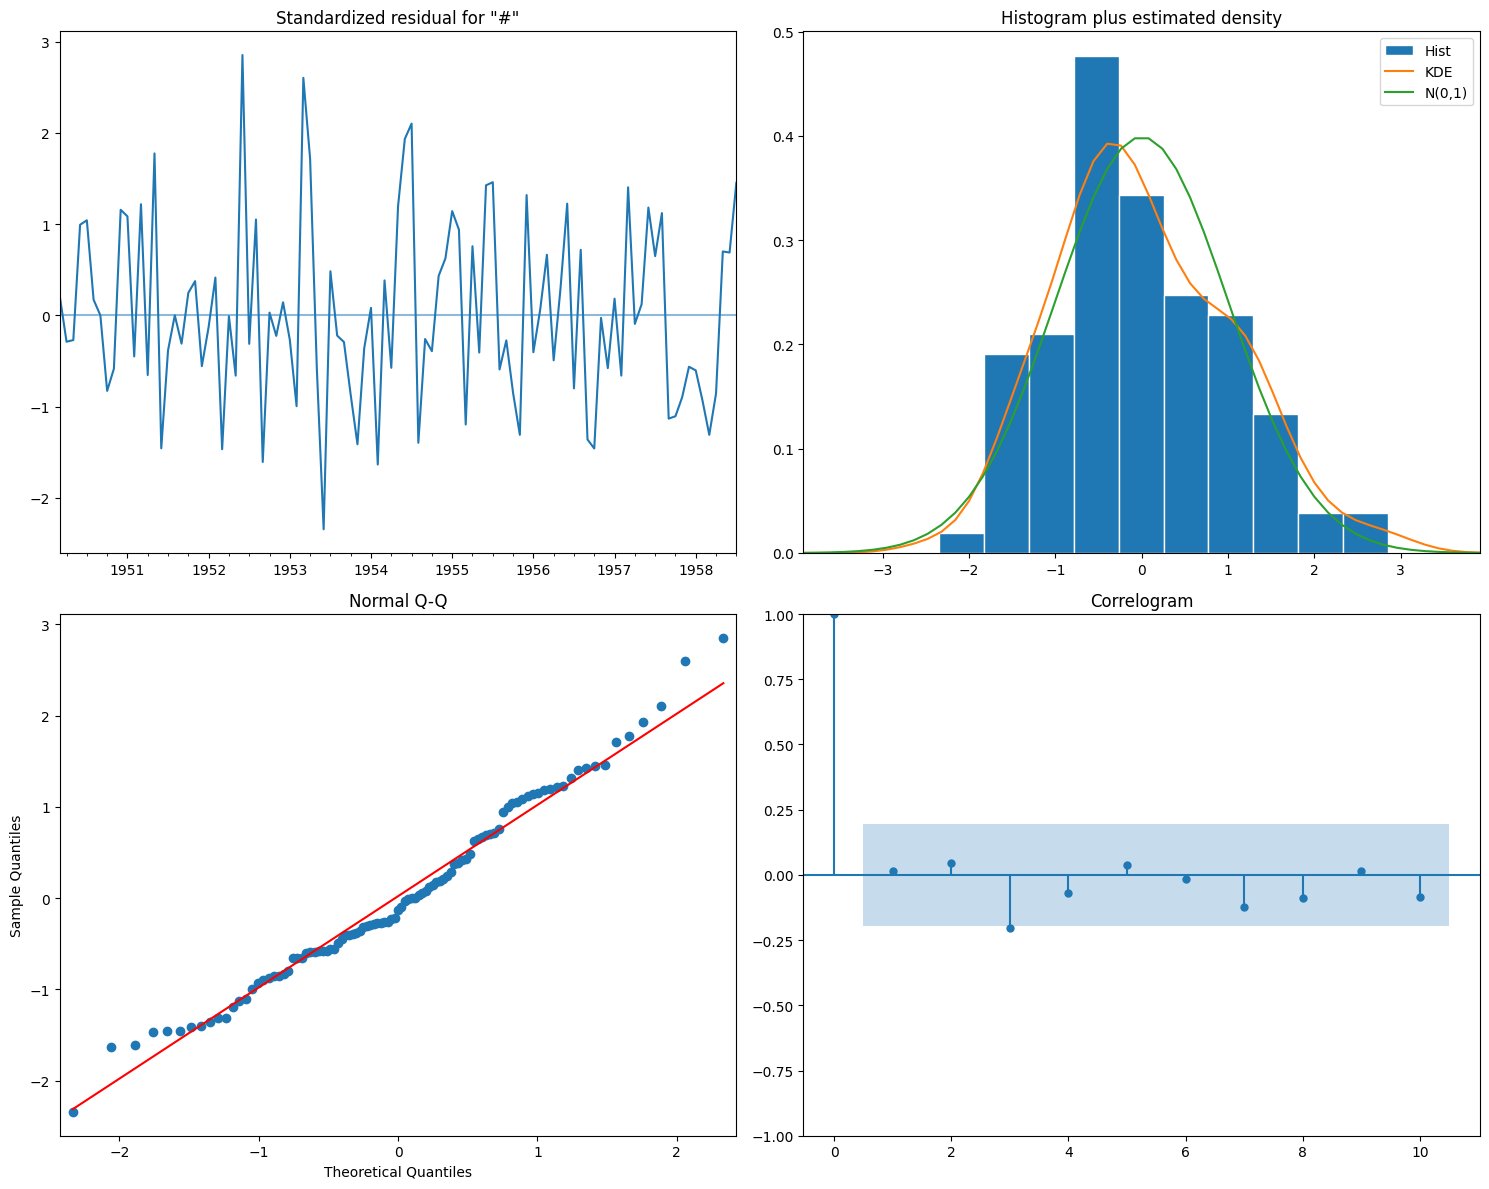

In [8]:
# Print the model summary
print("\n--- Model Summary ---")
print(results_sm.summary())

# Generate and save the diagnostics plot
results_sm.plot_diagnostics(figsize=(15, 12))
plt.tight_layout()
plt.savefig('diagnostics_plot.png')

print("\nDiagnostics plot saved as 'diagnostics_plot.png'")